# Ensemble Models

One of the latest trends in artificial intelligence modelling can be summarised as "knowledge of the whole or the crowd". What this somewhat familiar phrase defines is the use of a multitude of so-called "weak" models in a meta-classifier. The aim is to generate a "strong" model based on the knowledge extracted by the "weak" models. For example, although it will be detailed later, multiple, much simpler Decision Trees are developed in a Random Forest. The combination of these ones in the Random Forest exceeds the performance of any of the individual models. The models that emerge in this way, as meta-classifiers or meta-regressors, are generically called **Ensemble models**.

Is is worth mentioned that these models may not be limited only to decision trees, but may instead be composed of any type of machine learning model that has been seen previously. They can even be mixed models where not all models have been obtained in the same way, but can be created through the combined use of several techniques such as K-NN, SVM, etc. Thus, the first criteria to classifify the ensemble models would be if they are homogeneous or heterogeneous models. However this is not the only criteria to classifity the ensemble models, in this unit, we will explore various ways of generating the models and how to combine them later on. We will also take a closer look at two of the most common techniques within ensemble models such as Random Forest and _XGBoost_.

## Data Preparation

Unlike the first tutorials, where the iris flower problem has been used as a benchmark, in this tutorial we will use a different one. The problem is also included in the UCI repository, although it is also small, the number of variables increases significantly and therefore it will give us some more room to explore. Specifically, it is a classic machine learning problem, which is informally called Rock or Mine? It is a small database consisting of 111 patterns corresponding to rocks and 97 to water mines (simulated as metal cylinders). Each of the patterns consists of 60 numerical measurements corresponding to a section of the sonar sequences. These values are already between 0.0 and 1.0, although it is worth normalising them to be on the safe side. These measurements represent the energy value of different wavelength ranges for a certain period of time.

We are going to use a couple of new packages in the process, more specificly, [DataFrames.jl](https://juliaai.github.io/DataScienceTutorials.jl/data/dataframe/) and [UrlDownload.jl](https://github.com/Arkoniak/UrlDownload.jl). Therefore, first thing first, ensure that the packages are correcly installed.

In [1]:
using Pkg;
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("UrlDownload")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


After that, the data will be downloaded if they are not already available, for which the following code can be used:

In [3]:
# using UrlDownload
# using DataFrames
# using CSV

# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
# data = urldownload(url, true, format=:CSV, header=false) |> DataFrame
# describe(data)

In [2]:
using DataFrames
using CSV

# Replace "your_file_path.csv" with the actual path to your downloaded CSV file
file_path = "./sonar.all-data.csv"

# Read CSV file into a DataFrame
data = CSV.File(file_path, header=true) |> DataFrame

# Display the DataFrame
show(data, allrows=true)


208×61 DataFrame
 Row │ Freq_1   Freq_2   Freq_3   Freq_4   Freq_5   Freq_6   Freq_7   Freq_8   ⋯
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.02     0.0371   0.0428   0.0207   0.0954   0.0986   0.1539   0.1601  ⋯
   2 │  0.0453   0.0523   0.0843   0.0689   0.1183   0.2583   0.2156   0.3481
   3 │  0.0262   0.0582   0.1099   0.1083   0.0974   0.228    0.2431   0.3771
   4 │  0.01     0.0171   0.0623   0.0205   0.0205   0.0368   0.1098   0.1276
   5 │  0.0762   0.0666   0.0481   0.0394   0.059    0.0649   0.1209   0.2467  ⋯
   6 │  0.0286   0.0453   0.0277   0.0174   0.0384   0.099    0.1201   0.1833
   7 │  0.0317   0.0956   0.1321   0.1408   0.1674   0.171    0.0731   0.1401
   8 │  0.0519   0.0548   0.0842   0.0319   0.1158   0.0922   0.1027   0.0613
   9 │  0.0223   0.0375   0.0484   0.0475   0.0647   0.0591   0.0753   0.0098  ⋯
  10 │  0.0164   0.0173   0.0

As it can be seen in the previos line, we have downloaded de data and pipe it, with the operator `|>`, into the function DataFrame. This is going to create an structure simular to a database table which is particular convinient to check for missing values or the ranges of the different variables. In fact, the library makes it particularly easy to deal with missing values with functions to fullfill or remove the samples with non-valid measures. However it is too long to see every single variable on the output report, if some queries are made we can identify  that here is no missing values. Additionally no variable is over 1.0 but some of them are not normalized. A similar structure can be found in other languages, like R or Python.

As an example, of this process lets make the an additional column in order to convert to categorical the las column 60 which has a **M** for each Mine and an **R** for each sample of rock.

In [4]:
insertcols!(data, :Mine => data[:, 61].=="M")

Row,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,Freq_11,Freq_12,Freq_13,Freq_14,Freq_15,Freq_16,Freq_17,Freq_18,Freq_19,Freq_20,Freq_21,Freq_22,Freq_23,Freq_24,Freq_25,Freq_26,Freq_27,Freq_28,Freq_29,Freq_30,Freq_31,Freq_32,Freq_33,Freq_34,Freq_35,Freq_36,Freq_37,Freq_38,Freq_39,Freq_40,Freq_41,Freq_42,Freq_43,Freq_44,Freq_45,Freq_46,Freq_47,Freq_48,Freq_49,Freq_50,Freq_51,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label,Mine
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String1,Bool
1,0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.066,0.2273,0.31,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.555,0.6711,0.6415,0.7104,0.808,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.051,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,R,false
2,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.325,0.32,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.184,0.197,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.053,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,R,false
3,0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598,0.6194,0.6333,0.706,0.5544,0.532,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.507,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.013,0.0106,0.0033,0.0232,0.0166,0.0095,0.018,0.0244,0.0316,0.0164,0.0095,0.0078,R,false
4,0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.406,0.3973,0.2741,0.369,0.5556,0.4846,0.314,0.5334,0.5256,0.252,0.209,0.3559,0.626,0.734,0.612,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.321,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.015,0.0085,0.0073,0.005,0.0044,0.004,0.0117,R,false
5,0.0762,0.0666,0.0481,0.0394,0.059,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.573,0.5399,0.3161,0.2285,0.6995,1.0,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.243,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.023,0.0046,0.0156,0.0031,0.0054,0.0105,0.011,0.0015,0.0072,0.0048,0.0107,0.0094,R,false
6,0.0286,0.0453,0.0277,0.0174,0.0384,0.099,0.1201,0.1833,0.2105,0.3039,0.2988,0.425,0.6343,0.8198,1.0,0.9988,0.9508,0.9025,0.7234,0.5122,0.2074,0.3985,0.589,0.2872,0.2043,0.5782,0.5389,0.375,0.3411,0.5067,0.558,0.4778,0.3299,0.2198,0.1407,0.2856,0.3807,0.4158,0.4054,0.3296,0.2707,0.265,0.0723,0.1238,0.1192,0.1089,0.0623,0.0494,0.0264,0.0081,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R,false
7,0.0317,0.0956,0.1321,0.1408,0.1674,0.171,0.0731,0.1401,0.2083,0.3513,0.1786,0.0658,0.0513,0.3752,0.5419,0.544,0.515,0.4262,0.2024,0.4233,0.7723,0.9735,0.939,0.5559,0.5268,0.6826,0.5713,0.5429,0.2177,0.2149,0.5811,0.6323,0.2965,0.1873,0.2969,0.5163,0.6153,0.4283,0.5479,0.6133,0.5017,0.2377,0.1957,0.1749,0.1304,0.0597,0.1124,0.1047,0.0507,0.0159,0.0195,0.0201,0.0248,0.0131,0.007,0.0138,0.0092,0.0143,0.0036,0.0103,R,false
8,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,

Once the data is loaded in the DataFrame for the checking proposes and that any posible process has been applied on the data. As in previous tutorials, the data has to be put on a Matrix form, such as: 

In [5]:
input_data = Matrix(data[!, 1:60]);
output_data = data[!, :Mine];

@assert input_data isa Matrix
@assert output_data isa BitVector

It is worth to mention that in a DataFrame when a set of lines is queried such as in the case of the `X`, the results is also a DataFrame. Therefore, in order to applied the remaining operations it is needed to applied the `Matrix` function to retrive a matrix where the previous operations can be used as usual.

### Question

Now, the data is loaded and converted to the usual types. Now you should be able to apply in the next section and make asplit of the dataset in two subset, test and training, and apply the corresponding normalization. Put the code on the following section to perform both operations.

In [6]:
#train_input, train_output, test_input, test_output = #TODO
include("functions.jl")

train_indexes, test_indexes = holdOut(size(input_data, 1), 0.2)

train_input = input_data[train_indexes, :]
train_output = output_data[train_indexes, :]

test_input = input_data[test_indexes, :]
test_output = output_data[test_indexes, :]

@assert size(test_input, 1) == size(test_output, 1)
@assert size(train_input, 1) == size(train_output, 1)

## Baseline

As mentioned above, ensembles are a set of "weaker" classifiers that allow us to later overcome their limits by joining them together. That is why, before starting with ensembles, it will be necessary to have some reference models that will later be joined together in a meta-classifier. In the following example, some simple models, from `scikit-learn` library, are trained: an SVM with RBF kernel, a Linear Regression, a Naïve Bayes and a Decision Tree.

In [7]:
using Random

Random.seed!(33)

TaskLocalRNG()

In [8]:
using ScikitLearn

@sk_import svm:SVC
@sk_import tree:DecisionTreeClassifier
@sk_import linear_model:LogisticRegression
@sk_import naive_bayes:GaussianNB
@sk_import neighbors: KNeighborsClassifier;


#Define the models to train
models = Dict( "SVM" => SVC(probability=true), 
         "LR" =>LogisticRegression(),
         "DT"=> DecisionTreeClassifier(max_depth=4),
         "NB"=> GaussianNB())

base_models =  [ name for name in keys(models)]

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base conda




4-element Vector{String}:
 "NB"
 "SVM"
 "LR"
 "DT"

In [9]:
# Perform the training for each model and calculate the test values (accuracy)
for key in keys(models)
    model = models[key]
    fit!(model,train_input, train_output)
    acc = score(model,test_input, test_output)
    println("$key: $(acc*100) %")
end

NB: 57.14285714285714 %
SVM: 73.80952380952381 %
LR: 71.42857142857143 %
DT: 73.80952380952381 %


/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Combining weak models in an ensemble

When it comes to combining the models, there are different strategies depending on the task of the model, i.e. whether we are classifying or regressing. In this particular case we are going to focus on classification, although for regression it would be similar, but the continuous nature of the values should be taken into account when combining the outputs.

Regarding the combination of the classification, there are mainly two ways to combine the outputs of several classifiers. These combinations are called Majority voting and Weighted majority voting.

### Majority Voting
Although also known as Hard Voting, as the name suggests, they are based on selecting the most voted option among the predicted ones among the different models. The implementation available in scikit learn makes a sum of the predictions for each of the classes and then averages these estimates. The option selected by majority among the "experts" of which the emsemble consists is the one selected. In this way, the problem could be solved taking into account different results or points of view on the problem. See an example in the code below of constructing such a model.

In [10]:
@sk_import ensemble:VotingClassifier

#Define the metaclassifier based on the base_models
models["Ensemble (Hard Voting)"] = VotingClassifier(estimators = [(name,models[name]) for name in base_models], 
                                                   n_jobs=-1)
fit!(models["Ensemble (Hard Voting)"], train_input, train_output)

for key in keys(models)
    model = models[key]
    acc = score(model,test_input, test_output)
    println("$key: $(acc*100) %")
end

NB: 57.14285714285714 %
SVM: 73.80952380952381 %
LR: 71.42857142857143 %
DT: 73.80952380952381 %
Ensemble (Hard Voting): 71.42857142857143 %


/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


As can be seen, while it does not improve on the best of the component models, this is because, firstly, this is not a particularly complex problem. In addition, another problem is that we rely equally on all models when deciding on the response class. To solve this problem, it is possible to make it so that not all models are of equal importance, as we will see in the next section.

### Weigthed Mayority Voting 
As mentioned in the previous section, one of the problems of the classical *emsemble* model is that all outcomes are weighted equally and in each of the "weak" models only the most voted option is taken into account. To solve this, one of the proposals is the use of a weighting in the decision weights. This is because one model may be better than another or more reliable. In order to reflect this point, the output can be modified by multiplying it by a confidence factor within the rule used to make the decisions. This weighting procedure is sometimes also referred to as *Soft Voting* in contrast to *Hard Voting* or unweighted voting. Imagine that each of the classifiers is assigned the same weight, i.e. {1,1,1}. In an example like the following with an SVM, a Logarithmic regression and a Bayes-based model we would have the following outputs.

|Classifier	     |Mine	        |Rock          |
| :------------- | :----------: | -----------: |
|SVM         	 | 0.9	    | 0.1      |	
|LR         	 | 0.3	    | 0.7      |	
|NB         	 | 0.2	    | 0.8      |
|Soft Voting      |0.47	        |0.63          |	

Therefore, the selected class would be the Rock class since all models weigh the same in the decision making process when averaging. In contrast, if we know that one of the models is better, we can weight the response of that model. Imagine in the previous example if you knew that SVM is usually much better than the other two for this particular problem. In that case, you can increase its weight as seen below in order to take that model more into account. With the same example, but with SVM's answer being larger, the results would be:

|Classifier	     |Mine	        |Rock          |
| :------------- | :----------: | -----------: |
|SVM         	 |2 * 0.9	    |2 * 0.1      |	
|LR         	 |1 * 0.3	    |1 * 0.7      |	
|NB         	 |1 * 0.2	    |1 * 0.8      |
|Soft Voting      |0.575	        |0.425          |

As can be seen from the results, if we have a higher quality model, the outputs of this model will be taken into account more in terms of making the corresponding decision.

To implement this type of behaviour, you can simply add two additional parameters to the `VotingClassifier` function that was previously used to weight the output.

In [11]:
models["Ensemble (Soft Voting)"] = VotingClassifier(estimators = [(name,models[name]) for name in base_models], 
                                                   n_jobs=-1, voting="soft",weights=[1,2,1,2])
fit!(models["Ensemble (Soft Voting)"],train_input, train_output)

for key in keys(models)
    model = models[key]
    acc = score(model,train_input, train_output)
    println("$key: $(acc*100) %")
end

NB: 71.6867469879518 %
SVM: 91.56626506024097 %
LR: 87.34939759036145 %
DT: 94.57831325301204 %
Ensemble (Hard Voting): 90.36144578313254 %
Ensemble (Soft Voting): 93.97590361445783 %


/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


As you can see, the results are better when you combine several models that give good results. In fact, this procedure is the basis of other techniques such as the *Random Forest* that we will see a little later in this tutorial. The models to be used are the other key to the creation of _ensemble_, in the next section we will see the most common strategies for the creation of the models.

The adjustment of these weights can be done in many different ways, for example, it can be done manually as we have done in the previous example. Another alternative would be to use a gradient descent technique to adjust them as if it were a neural network or an SVM. Another possibility is to use the fit value on the validation set (in this case a dataset has not been reserved for this purpose) as the weight of the models.

### Question
We have perform every single test with a hold-out strategy, however, as it was appointed in a previous session, the application of a cross-validation approach is prefered to cut the dependency on the selection of the samples. In this case you could think that there are two different approaches one is apply the cross-validation to each model, choose the better one and combine those in a single ensemble. The other way arround would be applying the cross-validation at ensemble level before training the models. Which one is correct and why?

`Answer here`

### Stacking

This last approach to combining the models can be considered as a variant of Soft Voting. As mentioned in that section, soft voting allows the weights of each of the models to be fixed and this can be adjusted with a decaying gradient technique. Stacking is usually identified as creating a classification technique superior to a linear regression (which is what Soft Voting does) such as an ANN to combine the models.

Thus, as has been done previously, the outputs of the different techniques could be taken and used as inputs to another classification model, allowing for the adjustment of the weights and the non-linear combinations of the responses of each one.

You can see an example or this in the following code, which uses the implementation on `scikit=learn` whcih uses an SVC as compbining model:

In [12]:
@sk_import ensemble:StackingClassifier

models["Ensemble (Stacking)"] = StackingClassifier(estimators=[(name,models[name]) for name in base_models],
    final_estimator=SVC(probability=true), n_jobs=-1)
fit!(models["Ensemble (Stacking)"], train_input, train_output)

/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


PyObject StackingClassifier(estimators=[('NB', GaussianNB()),
                               ('SVM', SVC(probability=True)),
                               ('LR', LogisticRegression()),
                               ('DT', DecisionTreeClassifier(max_depth=4))],
                   final_estimator=SVC(probability=True), n_jobs=-1)

In [13]:
for key in keys(models)
    model = models[key]
    acc = score(model,train_input, train_output)
    println("$key: $(acc*100) %")
end

NB: 71.6867469879518 %
SVM: 91.56626506024097 %
LR: 87.34939759036145 %
DT: 94.57831325301204 %
Ensemble (Hard Voting): 90.36144578313254 %
Ensemble (Soft Voting): 93.97590361445783 %
Ensemble (Stacking): 90.96385542168674 %


## Model creation

One of the key elements that has not yet been addressed is the creation of the models that will compose the meta-classifier. So far, the approach that has been followed is not very adequate as the input dataset for all models is the same. This has the effect of an obvious lack of diversity in the models since whichever model we create, it will have the same information or "point of view" as the others. However, this is not the usual practice. Instead, the set of input patterns is usually divided into smaller sets with which to train one or more techniques in order to reduce the computational cost on the one hand, and to increase the diversity of the models on the other. It is necessary to remember at this point that "weak" models do not have to be perfect in all classes and do not even have to cover all possibilities, only models that are quick to train and offer a more or less consistent output.

As for the way in which to partition the data for the creation of the models, most approaches usually consider two main approaches known as *Bagging* and *Boosting*. In the following, these two approaches will be briefly described.

### Bagging or boostrap aggregation
The technique known as _Bagging_ or selection with replacement was proposed by Breitman in 1996. It is based on the development of multiple models which can be trained in parallel. The key element of these models is that each model is trained on a subset of the training set. This subset of data is drawn randomly with replacement. This last point is particularly important because once an example has been selected from the possibilities, it is placed back among the possibilities so that it can be selected either in the subset being built, or in the subsets of the other models, i.e. non-disjoint sets of examples are created.

![Bagging Example](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png)

The result is that "experts" are created on specialised data and depending on the partition. While common, or more frequent, data is correctly covered by all models, it is also true that less frequent data tends not to be in all partitions and may not be covered in all cases. Thus, you would get models that would be more specialised in certain data or have a different point of view, that would be experts in a particular region of the search space.

Although it will be discussed in more detail later, a well-known technique that uses this approach for the construction of its "weak" models is RandomForest. It builds the decision trees that make up the metaclassifier in this way. Any classifier can be used as the basis of a *Bagging* with the class [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html). 

For example, in the following code, 10 SVM for classication has been chosen as weak models. Each of those models habe been trained on only 50% of the training patterns, and therefore the variance among them should be increased.
 

In [14]:
@sk_import svm:SVC
@sk_import ensemble:BaggingClassifier

models["Bagging (SVC)"] = BaggingClassifier(base_estimator=SVC(),n_estimators=10, max_samples=0.50, n_jobs=-1)
fit!(models["Bagging (SVC)"], train_input, train_output)

for key in keys(models)
    model = models[key]
    acc = score(model,train_input, train_output)
    println("$key: $(acc*100) %")
end

NB: 71.6867469879518 %
SVM: 91.56626506024097 %
LR: 87.34939759036145 %
DT: 94.57831325301204 %
Ensemble (Hard Voting): 90.36144578313254 %
Ensemble (Soft Voting): 93.97590361445783 %
Ensemble (Stacking): 90.96385542168674 %
Bagging (SVC): 82.53012048192771 %


/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


As an alternative to extracting complete examples, a vertical partition of the training _dataset_ could be performed, thus extracting features. To implement this alternative, in the `BaggingClassifier` function, the parameter *max_features* must be defined. This approach is used when the number of features is particularly high in order to create simpler models that do not use all the information that is often redundant. It should be noted that this feature extraction procedure for models is done without replacement, i.e. features extracted for one classifier are not re-entered into the list of possibilities until the set for the next classifier is created.

### Boosting
The other major family of techniques for ensemble metamodelling is what is known as *Boosting*. In this case, the approach is slightly different, since the aim is to create a chain of classifiers. The key element of this type of classifier is to find that each new classifier is more specialised in the patterns that the previous models have missed. Therefore, as in the previous case, a subset of patterns is selected from the original set. However, this process is done sequentially and without replacement. This point is crucial since, as mentioned above, the idea is to eliminate those patterns that are already correctly classified and to obtain more specific models that concentrate on those examples that are less frequent or that have been incorrectly classified in a previous step. Thus, as in *Bagging*, the underlying idea of this approach is that not all models have to have all patterns as a basis, but unlike _Bagging_, this process is linear because of the dependency in the construction of the models. 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Ensemble_Boosting.svg/1920px-Ensemble_Boosting.svg.png" alt="Boosting examples" width="600"/>

Subsequently, to obtain the combination of the models, the Majority Vote with weights is used. In this approach, the weights are established with an iterative approximation system. There are many examples that use this type of technique, such as [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) or [Gracient Tree Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). In both cases what is done is an adjustment of the weights with a technique based on the Descending Gradient. 

In the case of AdaBoost, the algorithm starts by giving a weight to all the instances of the training set. With this weighted set, a classifier is trained with the original data. Depending on the errors made, the weights of the original set are adjusted and a new copy of the classifier is trained, but on the adjusted data, which will focus more on the instances that have been classified incorrectly. In the case of `scikit learn`, the algorithm implemented is known as [AdaBoost-SAMME](https://hastie.su.domains/Papers/SII-2-3-A8-Zhu.pdf) proposed by Zhu et.al. in 2009. As a particularity of this implementation, the *loss* function used is an exponential one. This is the one that will be used to calculate the weighting of the errors made, as well as the weight of the classifiers in the meta-classifier. In general terms, the output will be the most voted by the classifiers based on the weighting of each of them. 

Gradient Tree Boosting is a different approach to the use of Boosting. It builds a tree where the nodes of the tree set the criteria for, for example, in the case of classification refer to the `logistic-likelihood` of a given pattern. In this way, each of the nodes of the tree makes a classification which is adjusted on the basis of the residual errors that are made by adjusting the weights of the different classifiers in the tree. This division is carried out for each of the available features, performing a recursive procedure by training several classifiers in this way. Subsequently, to make the decision, it is based on the responses of the classifiers it has passed through. The main difference with AdaBoost is that in this case the output is the probabilities of the classes which are summed to give the most likely answer rather than the answer over the instances.

Below, we see an approach with an example of using these two metaclassifiers that make use of _Boosting_.

In [15]:
@sk_import ensemble:(AdaBoostClassifier, GradientBoostingClassifier)

models["Ada"] = AdaBoostClassifier(n_estimators=30)
fit!(models["Ada"], train_input, train_output)

models["GTB"] = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0, max_depth=2, random_state=0)
fit!(models["GTB"], train_input, train_output)

for key in keys(models)
    model = models[key]
    acc = score(model,test_input, test_output)
    println("$key: $(acc*100) %")
end


NB: 57.14285714285714 %
SVM: 73.80952380952381 %
LR: 71.42857142857143 %
DT: 73.80952380952381 %
Ensemble (Hard Voting): 71.42857142857143 %
Ensemble (Soft Voting): 64.28571428571429 %
Ada: 80.95238095238095 %
Ensemble (Stacking): 80.95238095238095 %
GTB: 78.57142857142857 %
Bagging (SVC): 71.42857142857143 %


/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alexdopico/.julia/conda/3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Question
In a similar way as in the cross-validation section, develop a funtion to train ensembles. The function called trainClassEmsemble, would also follow an stratified cross-validation. As a quick remember of the steps need to cover in the function:
1. Create a vector with k elements, which will contain the test results of the cross-validation process with the selected metric.  

2. Make a loop with k iterations (k folds) where within each iteration from the matrices of desired inputs and outputs, by means of the vector of indices resulting from the previous function, 4 matrices are created: desired inputs and outputs for training and test. 

3. Within this another loop, add a call to generate the models, which can be any of the ones used in Unit 6. 

4. Train those models by using the corresponding training set, i. e., the remaining K subsets non used for testing.

5. In case a validation set is needed, e.g. wi, split the training set into two parts. To do this, use the holdOut function. 

4. Build the ensemble following one of the strategies described above (any of them) and calculate the test.  


6. Finally, provide the result of averaging the values of these vectors for each metric together with their standard deviations. 

As a result of this call, at least the test value in the selected metric(s) should be returned. 

In [18]:
function splitCrossValidationData(
    trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}},
    numFold::Int64, 
    kFoldIndices::Array{Int64,1})

    inputs, targets = trainingDataset

    trainingInputs = inputs[kFoldIndices .!= numFold, :]
    trainingTargets = targets[kFoldIndices .!= numFold, :]
    
    testInputs = inputs[kFoldIndices .== numFold, :]
    testTargets = targets[kFoldIndices .== numFold, :]

    return (trainingInputs, trainingTargets, testInputs, testTargets)

end

function create_model(modelType::Symbol, modelHyperparameters::Dict)
    if modelType == :SVM
        return SVC(kernel=modelHyperparameters["kernel"],
                   degree=modelHyperparameters["degree"],
                   gamma=modelHyperparameters["gamma"],
                   C=modelHyperparameters["C"])
    elseif modelType == :kNN
        return KNeighborsClassifier(modelHyperparameters["numNeighboors"])
    elseif modelType == :DecisionTree
        return DecisionTreeClassifier(max_depth=modelHyperparameters["maxDepth"])
    else
        error("Model type not supported")
    end
end

function train_models(models::AbstractArray{Symbol, 1}, hyperParameters::AbstractArray{<:AbstractDict, 1}, trainingInputs, trainingTargets)
    Random.seed!(42)

    ensemble_models = []
    @assert length(models) == length(hyperParameters)
    
    # for (modelType, hyperParameter) in zip(models, hyperParameters)
    for i in 1:length(hyperParameters)
        modelType = models[i]
        hyperParameter = hyperParameters[i]

        model = create_model(modelType, hyperParameter)
        fit!(model, trainingInputs, vec(trainingTargets))

        name = "model_$(i)"

        push!(ensemble_models, (name, model))
    end

    return ensemble_models
end

function train_and_predict(model, trainingInputs, trainingTargets, testInputs, testTargets)
    Random.seed!(42)

    fit!(model, trainingInputs, vec(trainingTargets))
    testOutputs = predict(model, testInputs)
    
    testAccuracy, _, _, _, _, _, _, _ = confusionMatrix(testOutputs, vec(testTargets))
    
    return model, testAccuracy
end


function trainClassEnsemble(estimators::AbstractArray{Symbol,1}, 
        modelsHyperParameters:: AbstractArray{<:AbstractDict, 1},     
        trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}},    
        kFoldIndices::     Array{Int64,1})
    
    kFolds = maximum(kFoldIndices)
    testAccuracies = Array{Float64, 1}(undef, kFolds)
    testAccuraciesEnsemble = Array{Float64, 1}(undef, kFolds)

    for numFold in 1:kFolds
        (trainingInputs, trainingTargets, testInputs, testTargets) = splitCrossValidationData(trainingDataset, numFold, kFoldIndices)

        models = train_models(estimators, modelsHyperParameters, trainingInputs, trainingTargets)
        
        ensembleModel = VotingClassifier(estimators = models, n_jobs=-1, voting="hard")

        testAccuracies[numFold] = train_and_predict(ensembleModel, trainingInputs, trainingTargets, testInputs, testTargets)[2]
    end

    return (mean(testAccuracies), std(testAccuracies))

end

trainClassEnsemble (generic function with 1 method)

In [19]:
include("functions.jl")

dtParameters = Dict("maxDepth" => 13)
knnParameters = Dict("numNeighboors" => 13)
svmParameters = Dict("kernel" => "rbf", "C" => 1, "degree" => 3, "gamma" => 2)
Random.seed!(42)

kFolds = 10
crossValidationIndexes = crossvalidation(train_output, kFolds)
trainClassEnsemble([:DecisionTree, :kNN, :SVM], [dtParameters, knnParameters, svmParameters], (convert(Matrix{Float64}, train_input), convert(BitMatrix, train_output)), crossValidationIndexes)

(0.8333333333333334, 0.12001371663718259)

### Question
Repeted the previous function, but this time allowing to pass only one estimator as base. it can be replicated and pass to the previous function

In [20]:
function trainClassEnsemble(baseEstimator::Symbol, 
        modelsHyperParameters::AbstractDict,
        trainingDataset::Tuple{AbstractArray{<:Real,2}, AbstractArray{Bool,2}},     
        kFoldIndices::Array{Int64,1};
        NumEstimators::Int=100)
    
   estimators = fill(baseEstimator, NumEstimators)
   modelsHyperParameters = fill(modelsHyperParameters, NumEstimators)

   return trainClassEnsemble(estimators, modelsHyperParameters, trainingDataset, kFoldIndices)

end

trainClassEnsemble (generic function with 2 methods)

In [34]:
trainClassEnsemble(:DecisionTree, dtParameters, (train_input, train_output), crossValidationIndexes; NumEstimators=10)

(0.7333333333333333, 0.10734353145325509)

## Techniques integrating the Ensemble approach

Some of the best-known and currently used algorithms are based on this type of approach. Among these approaches, perhaps the most famous and widely used are those based on the generation of simple Decision Tress (DT). The reason for the use of the trees is their easy interpretation, as well as the speed of calculation and training. In the following we will see the two approaches known today in this sense, ***Random Forest*** and ***XGBoost***.


### Random Forest
This algorithm, proposed by Breitman and Cutler in 2006 on the basis of an earlier publication by Ho in 1995 (_Random Subspaces_), is the paradigm ensemble technique. The algorithm joins into an ensemble a set of simple classifiers that take the form of Decision Trees. These classifiers are trained following a **bagging** approach, and can therefore be trained in parallel. Combining the output of the algorithms is done for classification problems by means of the most voted option among the "experts" or, if it is a regression problem, by means of the arithmetic mean of the answers. 

It is an algorithm that needs the adjustment of very few hyperparameters to obtain very good results in almost any type of problem. In general, the most important value is the number of estimators and therefore the number of partitions to be made of the training set. Several authors point out that this number of estimators should be $\sqrt{\textrm{{\#}feature}}$  for classification problems, and *$\frac{\textrm{{\#}feature}}{3}$* for regression problems. However, he also points out that the technique would saturate between 500 and 1000 trees and no matter how much it is increased it would not improve results. However, this last point has only been tested empirically on certain data sets and, therefore, should be taken with caution as it has no mathematical justification.

In addition to the usual bagging process, the Random Forest also includes a second splitting mechanism. Once the patterns that will form part of the training set of the decision tree have been selected, only a subset of random features (*features*) are available for each node of the tree. This increases the diversity of the trees in the forest and focuses on the overall performance with a small variance in the results. This mechanism makes it possible to quantitatively assess the individual performance of each tree in the forest and its variables. Therefore, the importance of each variable can be measured. This measure that calibrates the participation of each variable in the nodes of the tree in decision-making is called impurity and measures the difference between the different branches of the tree when partitioning the examples. Sometimes, this same measure is used as a measure for the selection of variables by taking the measure in all the trees of the forest of the participation and importance by means of a filtering like those seen in the previous unit.

For the calculation of this measure of impurity, there are different approaches. For example, `scikit learn` uses a measure it calls **Gini**. The latter is the probability of misclassifying a randomly chosen item in the dataset if it were randomly labelled according to the distribution of classes in the dataset. It is calculated as:
$$G = \sum_{i=1}^C p(i) * (1 - p(i))$$

where $C$ is the number of classes and $p(i)$ is the probability of randomly selecting an element of class $i$. A good example of how to calculate the impurity of the branches can be seen in the following [link](https://victorzhou.com/blog/gini-impurity/)

Next, on the example used in this unit, we will run a *Random Forest* model with the `scikit learn` implementation. The most important parameters of this implementation are:

- ***n_estimator***, marking the number of trees to be generated or the number of *bagging* partitions.
- ***criterion***, measure of node impurity. By default Gini is used, but it can be changed to gained entropy.
- max_depth***, allows to limit the maximum depth of the trees in order to limit the number of variables to use.
- ***min_sample_split***, for each decision tree, how many patterns are needed to perform an internal split in the *Decision Trees*.
- bootstrap***, you can use the *bagging* or *bootstrap* approach to build the trees but if this property is false, then it uses the whole training set to generate the trees. In case of a True value, the following properties are taken into account:
    + ***max_samples***, number of examples to extract from the original set to build the training set of the estimator, the default value is equal to the number of patterns but remember that the same can be extracted several times as it is a selection with replacement giving variability.
    + ***oob_score***, *out of bag* measure for estimating generalisation. Those samples that have not been part of the training of an estimator can be used to calculate a validation measure, and averaged across all estimators to see how general the constructed forest is.
    
For example, the code below shows how to use the implementation in `scikit learn`:

In [161]:
@sk_import ensemble:RandomForestClassifier

models["RF"] = RandomForestClassifier(n_estimators=8, max_depth=nothing,
                                    min_samples_split=2, n_jobs=-1)
fit!(models["RF"], train_input, train_output)
    
for key in keys(models)
    model = models[key]
    acc = score(model,test_input, test_output)
    println("$key: $(acc*100) %")
end

NB: 76.19047619047619 %
SVM: 76.19047619047619 %
LR: 80.95238095238095 %
DT: 76.19047619047619 %
Ensemble (Hard Voting): 88.09523809523809 %
Ensemble (Soft Voting): 90.47619047619048 %
Ensemble (Stacking): 90.47619047619048 %
RF: 85.71428571428571 %


sys:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In this approach, the number of estimators has been defined following the aforementioned rule of $\sqrt{\textrm{{\#}features}}$. In this case, as there are few estimators and few patterns, the results may vary quite a lot depending on the type of partitions obtained.

Then, once the model has been trained, the level of impurity obtained for each of the frequencies calculated with the Gini algorithm can be computed as an average of those obtained among the trees that make up the forest. 

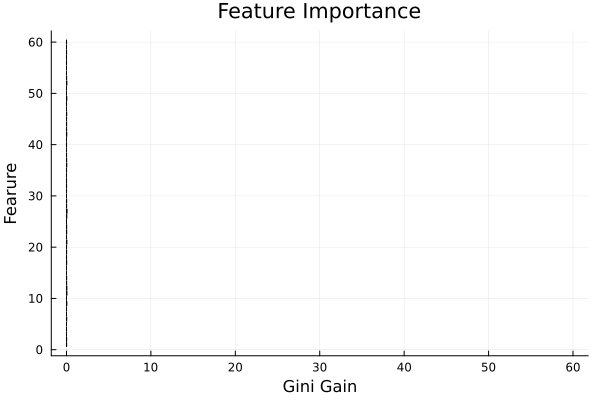

In [175]:
using Plots;

p = bar(y=1:60,models["RF"].feature_importances_, orientation=:horizontal, legend = false)
xlabel!(p,"Gini Gain")
ylabel!(p,"Fearure")
title!("Feature Importance")

It should be pointed out that, as can be seen in the graph, this value determines that most of the information is concentrated in some of the frequencies used. This is why a filtering of the information such as the ones we will see in the next session could be carried out based on this value. 

### XGBoost (eXtreme Gradient Boosting)

Finally, in this last section, Gradient Boosting should be mentioned again, specifically an implementation that in recent years has become very famous for its versatility and speed. This implementation is known as ***XGBoost (eXtreme Gradient Boosting)*** , which has stood out especially in competitions such as the Kaggle platform for its speed in obtaining results and robustness. 

The ***XGBoost*** will be a similar ensemble to Random Forest but uses a different base classifier known as CART (classification and regression trees) instead of *Decision Trees*. This change comes from the need for the algorithm to obtain the probability of the decisions, as was the case with *Gradient Tree Boosting*. The other fundamental change in this algotimo, since it is based on *Gradient Tree Boosting*, is the change from *bagging* to *boosting* strategy for the creation of the classifier training sets.

Subsequently, this technique performs an additive training approach whose weights are adjusted based on a **Declining Gradient** on a *loss* function to be defined. By adding the *loss* function with the regularisation term, the second derivative of the functions can be calculated in order to update the classification weights of the different trees. The calculation of this gradient thus allows the adjustment of the values of the classifiers that are generated following a given one in order to allow the weights to focus attention on the patterns that are incorrectly classified. The mathematical details of the implementation can be found in this [link](https://xgboost.readthedocs.io/en/stable/tutorials/model.html).

Unlike the other approaches we have seen, the `xgboost` is not currently implemented in `scikit learn`. For this reason, the reference version must be installed if it is not already present on the machine.

In [ ]:
using Pkg;
Pkg.add("XGBoost")

After that installation, the library could be used as shown in the following example. Unlike other implementations, the Julia implementation supports Julia Array, SparseMatrixCSC, libSVM format text and XGBoost binary file as input.  Althouugh the vastly options given by Julia libraría in deep to change internaly to the format [LIBSVM](https://xgboost.readthedocs.io/en/stable/tutorials/input_format.html) as any other library. This library has not all the posibilities and, more especificl, the BitVector is not supported nowadays in their function `DMatrix`. So, an small change in the format is required in order to use the library. 

In [178]:
using XGBoost;

train_input = input_data
train_output = output_data

test_input = input_data
test_output = output_data

train_output_asNumber= Vector{Number}(train_output);

@assert train_output_asNumber isa Vector{Number}

Once this data adaptation is done, you can proceed with the training of a model from the `xgboost` library. To do so, it is only necessary to call the function train with the corresponding parameters. Among these parameters, the most important are:

- **eta**, term that will determine the compression of the weights after each new stage of *boosting*. It takes values between 0 and 1.
- **max_depth**, maximum depth of the trees has by default a value of 6, increasing it will allow more complex models.
- **gamma**, parameter that controls the minimum loss reduction necessary to perform a new partition on a leaf node of the tree. The higher it is, the more conservative it will be
- **alpha** and **lambda**, are the parameters that control the L1 and L2 regulation respectively.
- **objective**, sets the loss function to be used which can be one of the predefined ones, which can be consulted in this [link](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)

Further it is only necessary to set the maximum number of iterations of the boosting process as shown in the following example with 20 rounds.

In [179]:
svm_data = DMatrix(train_input, label=train_output_asNumber)

model = xgboost(svm_data, rounds=20, eta = 1, max_depth = 6)

[ Info: XGBoost: starting training.
┌ Warning: [18:10:15] WARNING: /workspace/srcdir/xgboost/src/learner.cc:742: 
│ Parameters: { "rounds" } are not used.
└ @ XGBoost ~/.julia/packages/XGBoost/pHRDD/src/XGBoost.jl:35
[ Info: [1]	train-rmse:0.06685667952816027
[ Info: [2]	train-rmse:0.03784067051373981
[ Info: [3]	train-rmse:0.02057971291063566
[ Info: [4]	train-rmse:0.01269548720252575
[ Info: [5]	train-rmse:0.00709807877639992
[ Info: [6]	train-rmse:0.00428344147805759
[ Info: [7]	train-rmse:0.00305694459598080
[ Info: [8]	train-rmse:0.00142192344718740
[ Info: [9]	train-rmse:0.00098684141249462
[ Info: [10]	train-rmse:0.00068744187963404
[ Info: Training rounds complete.


Booster()

On the folllowing piece of code, several parameter as pass as a dictionary and two differnt metrics are calculated. First, error refers to the incorrect classified ones over the total amount and the second one is the Area Under Curbe ROC (AUC).

### Question
Which is the canonical name of the first measure that is been monitorized?

`It is called error rate. The formula is ` *$\frac{Number of Incorrect Predictions}{Total Number of Predictions}$*

In [283]:
param = ["max_depth" => 2,
         "eta" => 1,
         "objective" => "binary:logistic"]

metrics = ["error", "auc"]

# model = xgboost(DMatrix(train_input, label=train_output_asNumber), num_round = 20, max_depth = 2, eta = 1, objective = "binary:logistic"; eval_metric = metrics)
model = xgboost(DMatrix(train_input, label=train_output_asNumber), num_round = 20; kw = **param, eval_metric = metrics)

pred = XGBoost.predict(model, test_input)

accuracy(pred, test_output)

LoadError: syntax: use "x^y" instead of "x**y" for exponentiation, and "x..." instead of "**x" for splatting.

***Important***.

In case a validation set is used, this must be passed in the *evals* parameter of the training function. In addition, and only when the mentioned *evals* parameter is defined, you can set the rounds for the pre-stop with the *early_stopping_rounds* parameter of the training function. The code would be similar to:
``` julia
    evals = DMatrix(val_input, label=val_output)
    xgb_model = xgb.train(param, train_input, num_round,label = train_output_asNumber, evals=evals,
                    early_stopping_rounds=10)
```

The value provided in the output corresponds to the sum of the outputs of the trees, being between 0 and 1 for membership of a given class. Since this is a binary class, simply set a limit of 0.5 to the output to determine what the answer is.

In [300]:
using XGBoost: predict as predict_xgb

pred = predict_xgb(model, test_input)
print("Error of XGboost= ", sum((pred .> 0.5) .!= test_output) / float(size(pred)[1]), "\n")

Error of XGboost= 0.0


Finally, as in the case of the Random Forest it is possible to identify the importance and paint it for each of the variables in the ranking. With the following code it is possible to see such a marker ordered in a ascendent way

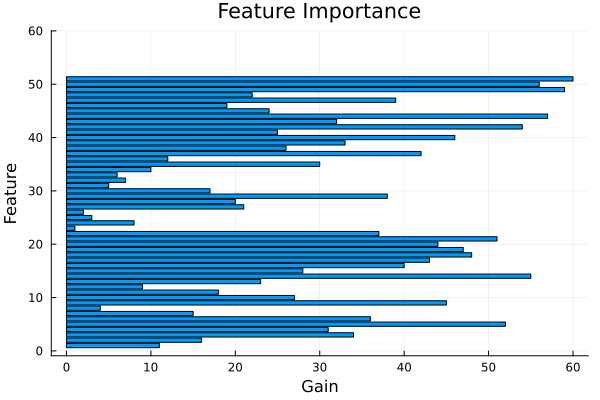

In [187]:
feature_gain =  [(first(x),last(x)) for x in importance(model)]
feature, gain = first.(feature_gain), last.(feature_gain)

using Plots;

p = bar(feature, y=gain, orientation="h", legend=false)
xlabel!(p,"Gain")
ylabel!(p,"Feature")
title!("Feature Importance")

As you can see, not all features has the same importance. It should be notice that the Feature axis identifies the position in the Vector  feature which is ordered by the gain value by default.